In [1]:
 !pip install fedartml
!pip install -q flwr[simulation]

In [2]:
import numpy as np
import os
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import SGD

from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

import pandas as pd

import matplotlib.pyplot as plt

import gc
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

from fedartml import InteractivePlots, SplitAsFederatedData

import flwr as fl
from typing import List, Tuple, Dict, Optional
from flwr.common import Metrics

In [3]:
# Define function to test a model and retrieve classification metrics
def test_model(model, X_test, Y_test):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    loss, acc = model.evaluate(X_test, Y_test, verbose=3)
    return loss, acc

# Define function to convert from SplitAsFederatedData function output (FedArtML) to Flower (list) format
def from_FedArtML_to_Flower_format(clients_dict):
  # initialize list that contains clients (features and labels) to extract later from client_fn in Flower
  list_x_train = []
  list_y_train = []

  # Get the name of the clients from the dictionary
  client_names = list(clients_dict.keys())

  # Iterate over each client
  for client in client_names:
    # Get data from each client
    each_client_train=np.array(clients_dict[client],dtype=object)

    # Extract features for each client
    feat=[]
    x_tra=np.array(each_client_train[:, 0])
    for row in x_tra:
      feat.append(row)
    feat=np.array(feat)

    # Extract labels from each client
    y_tra=np.array(each_client_train[:, 1])

    # Append in list features and labels to extract later from client_fn in Flower
    list_x_train.append(feat)
    list_y_train.append(y_tra)

  return list_x_train, list_y_train

def get_model():
    """Constructs a LeNet-5 model architecture suitable for MNIST."""
    model = Sequential([
        tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(84, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=SGD(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# Define local training/evaluation function
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train) -> None:
        self.model = model
        self.x_train, self.y_train = x_train, y_train

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=1,verbose=3, batch_size = 64, callbacks=[GarbageCollectorCallback()])
        return self.model.get_weights(), 1, {}

    def evaluate(self, parameters, config):
        return loss, len(self.x_test), {"accuracy": acc}


def plot_metric_from_history(
    hist: None,
    save_plot_path: None,
    metric_type: None,
    metric: None,
) -> None:

    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    # plt.plot(np.asarray(rounds), np.asarray(values), label="FedAvg")
    plt.plot(np.asarray(rounds), np.asarray(values), color=colors[5], linewidth=5, label='Test')
    plt.legend(fontsize=45)
    plt.xlabel('Communication round', fontsize=40)
    plt.ylabel(metric, fontsize=50)
    plt.title(metric, fontsize=60)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    # plt.ylim(min(min(min(commun_metrics))) - 0.05, max(max(max(commun_metrics))) + 0.05)
    plt.ylim(0, 1)

def retrieve_global_metrics(
    hist: None,
    metric_type: None,
    metric: None,
    best_metric: None,
) -> None:

    metric_dict = (
        hist.metrics_centralized
        if metric_type == "centralized"
        else hist.metrics_distributed
    )
    rounds, values = zip(*metric_dict[metric])
    if best_metric:
      metric_return = max(values)
    else:
      metric_return = values[-1]
    return metric_return

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Define random state for reproducibility
random_state = 0

# Define colors to use in plots
colors = ["#00cfcc","#e6013b","#007f88","#00cccd","#69e0da","darkblue","#FFFFFF"]

# Define number of local nodes to be used
local_nodes_glob = 10

# Define percentage of noniid to be used
Percent_noniid = 100

Alpha = 1

In [5]:
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical

# Define random state for reproducibility
random_state = 0

# Tải dữ liệu MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255
# Instantiate a SplitAsFederatedData object
my_federater = SplitAsFederatedData(random_state = random_state)

# Get federated dataset from centralized dataset
clients_glob_dic, list_ids_sampled_dic, miss_class_per_node, distances = my_federater.create_clients(image_list = train_images, label_list = train_labels,
                                                             num_clients = local_nodes_glob, prefix_cli='client', method = "percent_noniid", percent_noniid = Percent_noniid)

clients_glob = clients_glob_dic['with_class_completion']
list_ids_sampled = list_ids_sampled_dic['with_class_completion']

list_x_train, list_y_train = from_FedArtML_to_Flower_format(clients_dict=clients_glob)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Local node1 shape: (5923, 2)
Local node2 shape: (6742, 2)
Local node3 shape: (5958, 2)
Local node4 shape: (6131, 2)
Local node5 shape: (5842, 2)
Local node6 shape: (5421, 2)
Local node7 shape: (5918, 2)
Local node8 shape: (6265, 2)
Local node9 shape: (5851, 2)
Local node10 shape: (5949, 2)


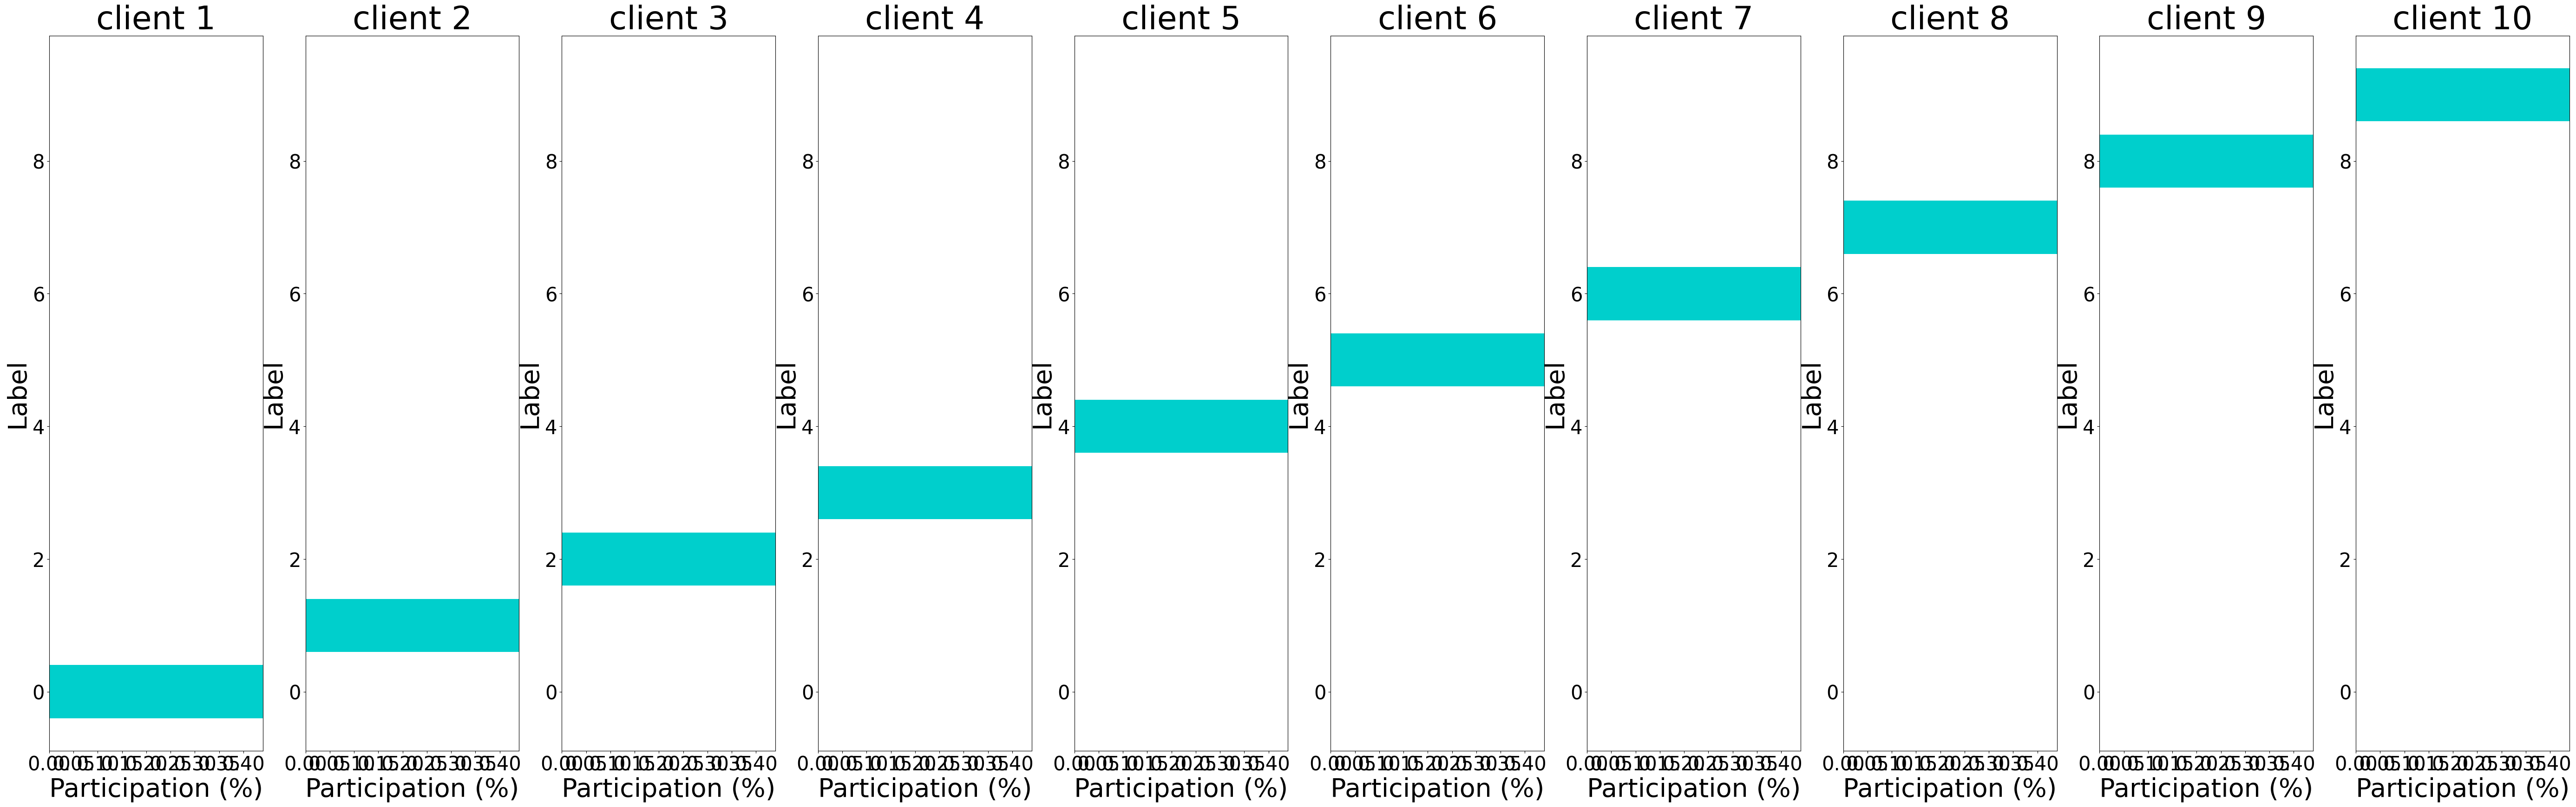

In [6]:
f, axs = plt.subplots(1,local_nodes_glob,figsize=(70,20))

# Initialize counter
cont = 0


max_xlab = 0.4 + 0.02
fl_append_labels = []

# Loop over the clients
for key, value in clients_glob.items():

  # Extract the labels
  labels_check = []
  for i in range(len(value)):
    val = value[i][1]
    labels_check.append(val)


  fl_append_labels = fl_append_labels + list(labels_check[:len(labels_check)-miss_class_per_node[cont]])

  labels_check = pd.DataFrame(labels_check,columns=["label"]).reset_index()


  # Get the number of diagnoses per diagnose
  group = labels_check.groupby(['label']).count().reset_index().sort_values(by=['label'], ascending = True)
  group['particip'] = group['index'].values / sum(group['index'].values)
  group.sort_values(by=['label'], ascending=False, inplace=True)

  print("Local node" + str(cont + 1) + " shape:",labels_check[:len(labels_check)-miss_class_per_node[cont]].shape)

  # Plot each client barplot
  max_group = max(group['particip'])
  max_xlab = np.min([max_xlab,max_group])
  plt.subplot(1, local_nodes_glob, cont + 1)
  plt.barh(group.label, group['particip'],alpha = 1, color=colors[0])
  plt.xlabel('Participation (%)', fontsize=40)
  plt.ylabel('Label', fontsize=40)
  plt.title(key.replace("_"," "), fontsize=50)
  plt.xticks(fontsize=30)
  plt.yticks(fontsize=30)
  plt.xlim(left=0, right=max_xlab + 0.02)
  # Increase counter
  cont += 1

In [7]:
# The `evaluate` function will be by Flower called after every round
def evaluate_DNN_CL(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    net = get_model()
    net.set_weights(parameters) # Update model with the latest parameters
    loss, accuracy = test_model(net, test_images, test_labels)
    gc.collect()
    return loss, {"accuracy": accuracy}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Define number of communication rounds
comms_round = 20

def client_fn(cid: str) -> fl.client.Client:
    # Define model
    model = get_model()

    # Load data partition of each client ID (cid)
    x_train_cid = np.array(list_x_train[int(cid)],dtype=float)
    y_train_cid = np.array(list_y_train[int(cid)],dtype=float)
    # Create and return client
    return FlowerClient(model, x_train_cid, y_train_cid)

# Create Federated strategy
strategy= fl.server.strategy.FedAvg(
        fraction_fit=1,  # Sample 100% of available clients for training
        fraction_evaluate=0,  # Sample 50% of available clients for evaluation
        min_fit_clients=10,
        min_evaluate_clients = 0,
        min_available_clients = 10,
        evaluate_fn=evaluate_DNN_CL
)
enable_tf_gpu_growth()
# Start simulation (training FL)
commun_metrics_history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=local_nodes_glob,
    config=fl.server.ServerConfig(num_rounds=comms_round),
    strategy=strategy,
    client_resources = {'num_cpus': 1, 'num_gpus': 0},
)

# Unmask metrics
global_acc_test = retrieve_global_metrics(commun_metrics_history,"centralized","accuracy",True)

print("\n\nFINAL RESULTS: ===========================================================================================================================================================================================")


INFO :      Starting Flower simulation, config: num_rounds=20, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=20, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-09 19:08:41,650	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3837773414.0, 'node:__internal_head__': 1.0, 'memory': 7675546830.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3837773414.0, 'node:__internal_head__': 1.0, 'memory': 7675546830.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize y



FINAL RESULTS: ===========================================================================================================================================================================================


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: 'losses_centralized'

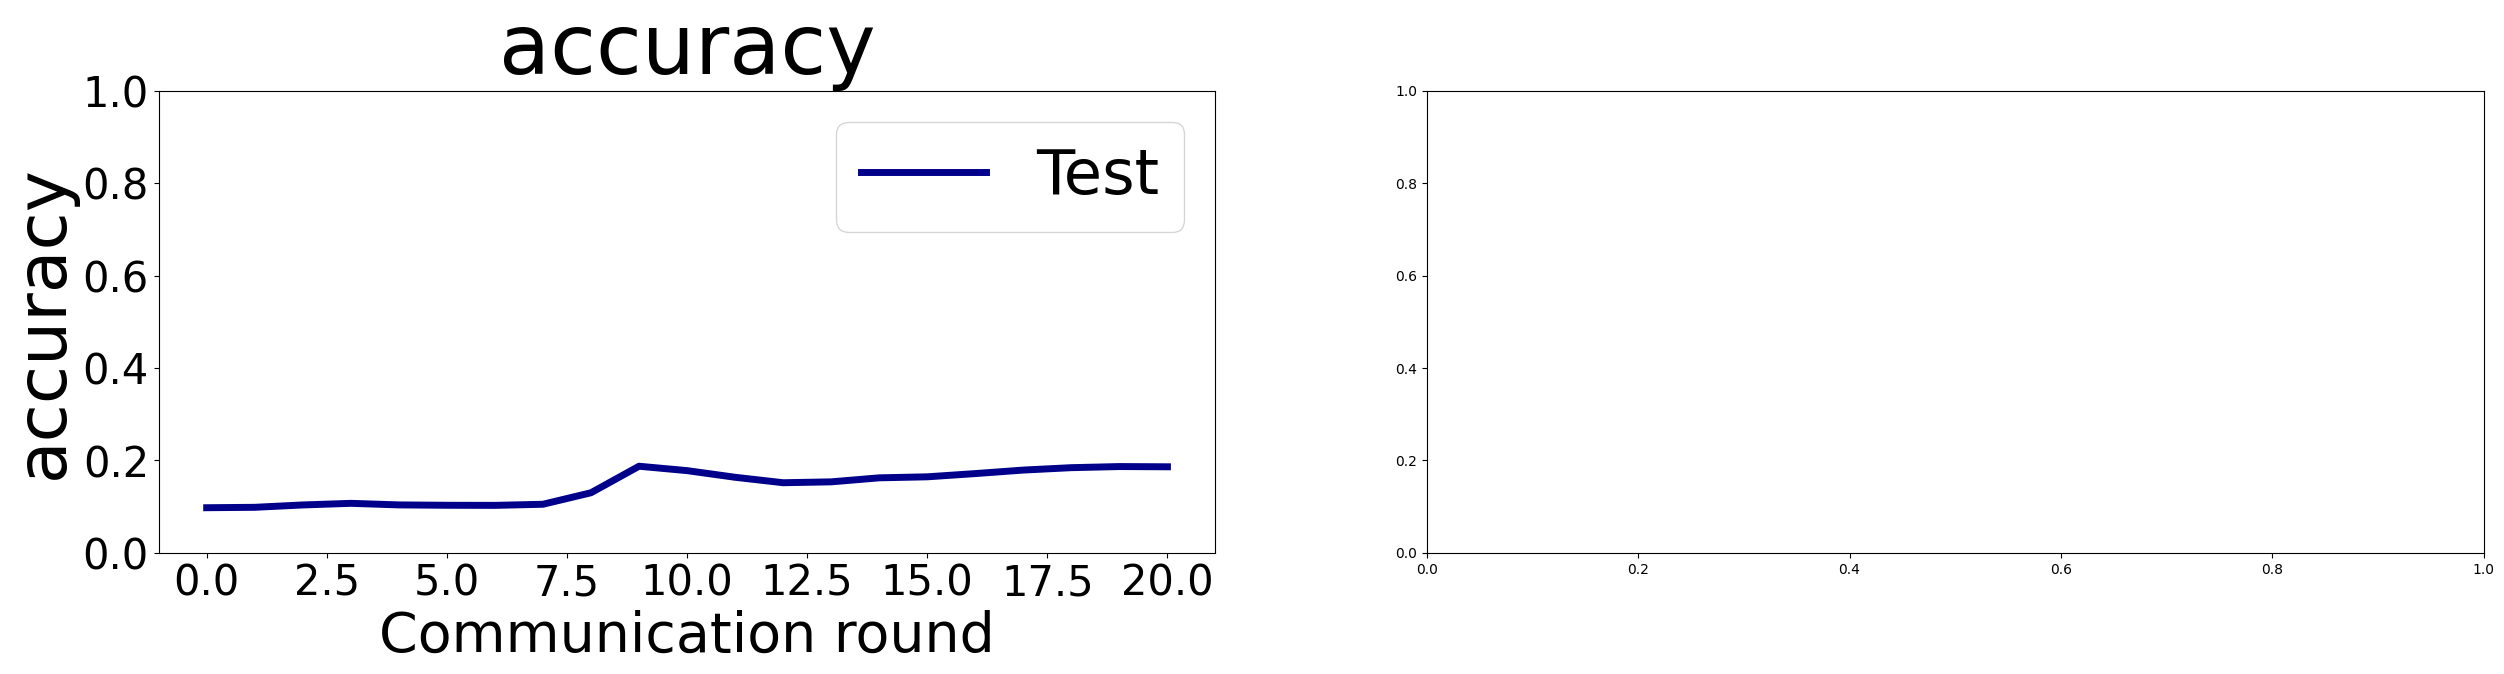

In [9]:
# Define metrics to plot
metrics_show = ["accuracy", "losses_centralized"]

# Define dimensions for plot
f, axs = plt.subplots(1,len(metrics_show),figsize=(30,6))

# Loop over the communication round history and metrics
for i in range(len(metrics_show)):
  plt.subplot(1, len(metrics_show), i + 1)
  plot_metric_from_history(commun_metrics_history,"any","centralized",metrics_show[i])

In [ ]:
commun_metrics_history